# Import Necessary Packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model, Sequential

In [17]:
data = pd.read_csv('./creditcard.csv')

In [18]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploring Data

In [19]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [20]:
X = data.drop(['Class', 'Time'], axis = 1)
y = data["Class"]

In [21]:
X_train, X_test,y_train,y_test = train_test_split(X,y, shuffle=True, test_size=0.3,random_state=42 )

# Defining Model

In [22]:
class Autoencoder(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
        ])
        
        self.code = Sequential([
            Dense(16,activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(32,activation='relu'),
            Dropout(0.2),
            Dense(64,activation='relu'),
            Dropout(0.2),
            Dense(29,activation='relu')
        ])
        
    def call(self, inputs, *args):
        encoded_inputs = self.encoder(inputs)
        code = self.code(encoded_inputs)
        decoded_inputs = self.decoder(code)
        return decoded_inputs

# Training the model

In [24]:
model = Autoencoder()
model.compile(loss='mse', optimizer='adam')

In [25]:

history = model.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 58.8548 - val_loss: 2.4252
Epoch 2/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 3.5034 - val_loss: 10.9418
Epoch 3/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.9911 - val_loss: 0.8919
Epoch 4/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 2.0422 - val_loss: 0.9769
Epoch 5/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 3.2747 - val_loss: 1.7733
Epoch 6/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 3.3780 - val_loss: 0.8799
Epoch 7/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 3.3718 - val_loss: 0.8928
Epoch 8/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.8596 - val_loss: 0.8910
Epoch 9/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1.5364 - val_loss: 1.0192
Epoch 10/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 3.0224 - val_loss: 0.9122


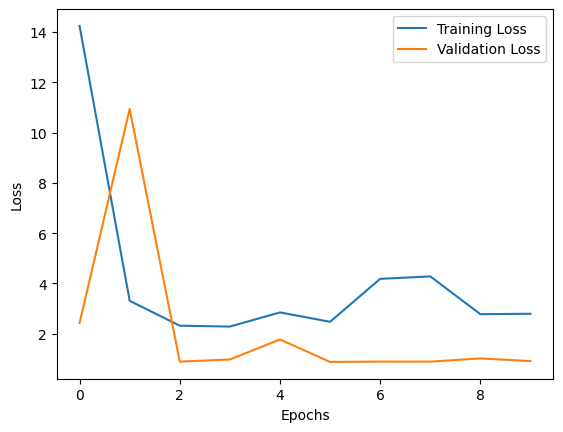

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Finding threshold for fraud transaction

In [32]:
def find_threshold(autoencoder_model : Model , train_data):
    # Reconstruct the input using autoencoder model
    reconstruction = autoencoder_model.predict(train_data)
    
    # Calculate the loss
    loss = tf.keras.losses.msle(train_data, reconstruction)
    
    # Calculate the threshold
    threshold = np.mean(loss.numpy()) + np.std(loss.numpy())
    
    return threshold



def get_predictions(autoencoder_model : Model , test_data, threshold):
    # Reconstruct the input using autoencoder model
    reconstruction = autoencoder_model.predict(test_data)
    
    # Calculate the loss
    loss = tf.keras.losses.msle(test_data, reconstruction)
    
    anomaly_mask = pd.Series(loss) > threshold
    
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    
    return preds


In [33]:
threshold = find_threshold(model, X_train)
print(f'Threshold: {threshold}')

6231/6231 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
Threshold: 0.18329888582229614


# Making Predictions

In [34]:
y_preds = get_predictions(model,X_test,threshold)

print(accuracy_score(y_test, y_preds))

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
0.12130894280397458
